## **5.1 Installing the Requred Libarary**

In [ ]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d mikaelstrauhs/airbus-ship-detection-train-set-70

Saving kaggle.json to kaggle.json
100% 18.5G/18.5G [05:13<00:00, 83.7MB/s]
100% 18.5G/18.5G [05:13<00:00, 63.4MB/s]


In [ ]:
from zipfile import ZipFile 
with ZipFile('airbus-ship-detection-train-set-70.zip', 'r') as Zip: 

    print('Extracting all the files now...') 
    Zip.extractall('data')


Extracting all the files now...


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
root_path = './gdrive/My Drive/segmentation/' 

In [ ]:
!pip install tensorflow==1.14.0
!pip install keras==2.2.5

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from skimage.morphology import label
import cv2

import os
import time
import sys
TRAIN_DATA_PATH = './data/train_v3/train_v3/Images'
SHIP_CLASS_NAME = 'ship'
IMAGE_WIDTH = 768
IMAGE_HEIGHT = 768
SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT)

MASK_RCNN_PATH = ',/Mask_RCNN-master'
train_ds = os.listdir(TRAIN_DATA_PATH)

print('train dataset from: {}, {}'.format(TRAIN_DATA_PATH, len(train_ds)))


train dataset from: ./data/train_v3/train_v3/Images, 134789


## **Encoding RLE(run-length-encoding)**'

In [ ]:
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_encode(img):
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


## **Decoding RLE(run-length-encoding)**

In [ ]:

def rle_decode(mask_rle, shape=(768, 768)):

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T 

def masks_as_image(in_mask_list):
    all_masks = np.zeros((768, 768), dtype = np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

## **Loading data**

In [ ]:
masks = pd.read_csv("./data/train_ship_segmentations_v3.csv")
masks.head()



## **Showing the Mask**

Text(0.5, 1.0, 'Image$_1$')

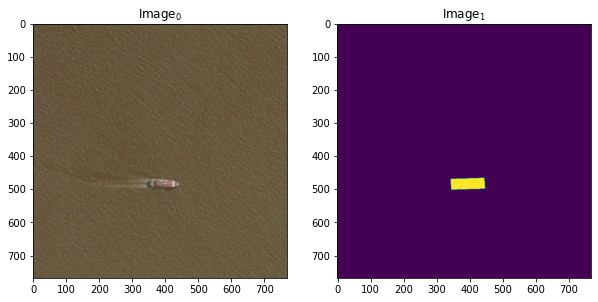

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
rle_0 = masks.query('ImageId=="000155de5.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
img = cv2.imread(os.path.join(TRAIN_DATA_PATH,"000155de5.jpg"))
ax1.imshow(img)
ax1.set_title('Image$_0$')
ax2.imshow(img_0[:, :, 0])
ax2.set_title('Image$_1$')


## **Split Train and Validation datasets**

unique_img_ids groupby took: 3.7604384422302246


,ImageId,ships,RleMaskList
110175,df57d6555.jpg,2,[435860 1 436626 4 437393 6 438160 6 438926 6 ...
79490,b66be05a5.jpg,1,[122328 1 123095 4 123863 6 124630 9 125398 11...
11972,2698091ee.jpg,2,[348704 3 349472 7 350240 10 351007 11 351775 ...


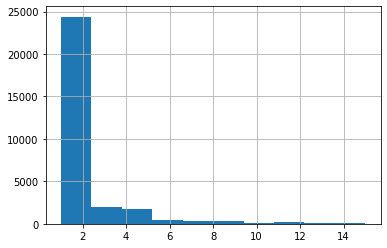

In [ ]:

masks['ships'] = masks['EncodedPixels'].map(lambda encoded_pixels: 1 if isinstance(encoded_pixels, str) else 0)

start_time = time.time()
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'})
unique_img_ids['RleMaskList'] = masks.groupby('ImageId')['EncodedPixels'].apply(list)
unique_img_ids = unique_img_ids.reset_index()
end_time = time.time() - start_time
print("unique_img_ids groupby took: {}".format(end_time))
unique_img_ids = unique_img_ids[unique_img_ids['ships'] > 0]
unique_img_ids['ships'].hist()
unique_img_ids.sample(3)

23844 training masks
5962 validation masks


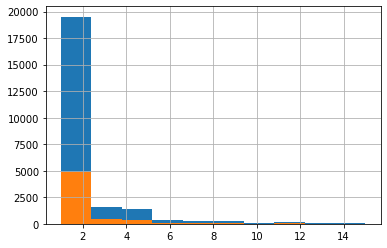

In [ ]:

from sklearn.model_selection import train_test_split
train_ids, val_ids = train_test_split(unique_img_ids, 
                 test_size = 0.2, 
                 stratify = unique_img_ids['ships'])
print(train_ids.shape[0], 'training masks')
print(val_ids.shape[0], 'validation masks')
train_ids['ships'].hist()
val_ids['ships'].hist()


## **Install Matterport's Mask-RCNN model from github.**

In [ ]:
import os

UPDATE_MASK_RCNN = False

if UPDATE_MASK_RCNN:
    !rm -rf {MASK_RCNN_PATH}

if not os.path.exists(MASK_RCNN_PATH):
    !git clone https://www.github.com/matterport/Mask_RCNN.git

sys.path.append('./Mask_RCNN')  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

## **Create dataset Class for MaskRcnn**

In [ ]:
class AirbusShipDetectionChallengeDataset(utils.Dataset):
    def __init__(self, image_file_dir, ids, masks, image_width=IMAGE_WIDTH, image_height=IMAGE_HEIGHT):
        super().__init__(self)
        self.image_file_dir = image_file_dir
        self.ids = ids
        self.masks = masks
        self.image_width = image_width
        self.image_height = image_height
        
        self.add_class(SHIP_CLASS_NAME, 1, SHIP_CLASS_NAME)
        self.load_dataset()
        
    def load_dataset(self):
        for index, row in self.ids.iterrows():
            image_id = row['ImageId']
            image_path = os.path.join(self.image_file_dir, image_id)
            rle_mask_list = row['RleMaskList']
            self.add_image(
                SHIP_CLASS_NAME,
                image_id=image_id,
                path=image_path,
                width=self.image_width, height=self.image_height,
                rle_mask_list=rle_mask_list)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        rle_mask_list = info['rle_mask_list']
        mask_count = len(rle_mask_list)
        mask = np.zeros([info['height'], info['width'], mask_count],
                        dtype=np.uint8)
        i = 0
        for rel in rle_mask_list:
            if isinstance(rel, str):
                np.copyto(mask[:,:,i], rle_decode(rel))
            i += 1
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info['source'] == SHIP_CLASS_NAME:
            return info['path']
        else:
            super(self.__class__, self).image_reference(image_id)

## ** Configration file for Mask Rcnn**

In [ ]:
class AirbusShipDetectionChallengeGPUConfig(Config):
    NAME = 'ASDC_GPU'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    NUM_CLASSES = 2  
    IMAGE_MIN_DIM = IMAGE_WIDTH
    IMAGE_MAX_DIM = IMAGE_WIDTH
    STEPS_PER_EPOCH = 300
    VALIDATION_STEPS = 50
    SAVE_BEST_ONLY = True
    DETECTION_MIN_CONFIDENCE = 0.95
    DETECTION_NMS_THRESHOLD = 0.05

config = AirbusShipDetectionChallengeGPUConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.05
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  768
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  768
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [768 768   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

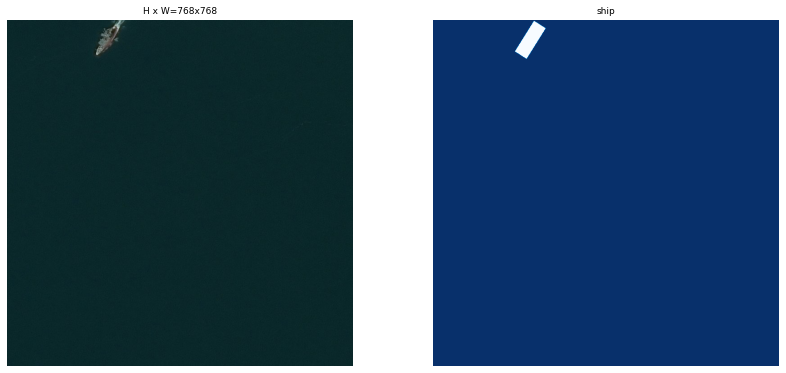

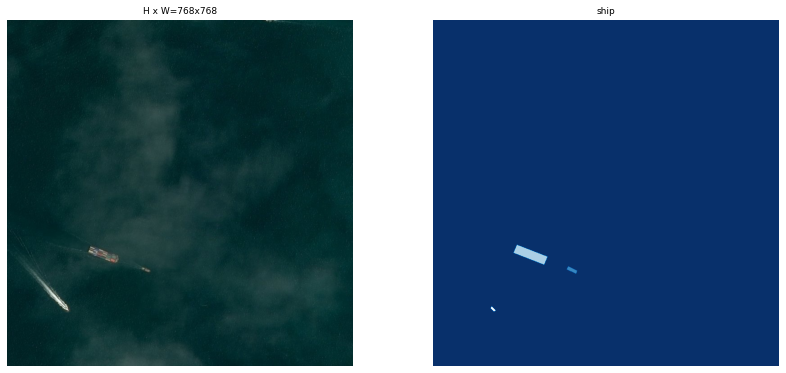

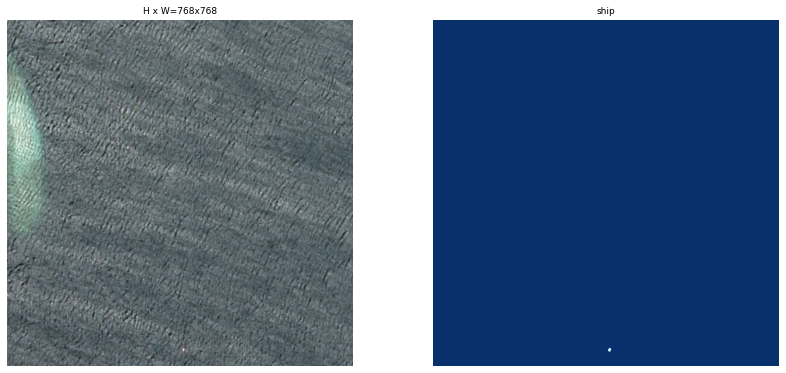

dataset prepare: 4.378681421279907


In [ ]:
start_time = time.time()
dataset_train = AirbusShipDetectionChallengeDataset(image_file_dir=TRAIN_DATA_PATH, ids=train_ids, masks=masks)
dataset_train.prepare()
dataset_val = AirbusShipDetectionChallengeDataset(image_file_dir=TRAIN_DATA_PATH, ids=val_ids, masks=masks)
dataset_val.prepare()

image_ids = np.random.choice(dataset_train.image_ids, 3)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)

end_time = time.time() - start_time
print("dataset prepare: {}".format(end_time))

## **Prediction**

In [ ]:
WORKING_DIR = './'
class InferenceConfig(AirbusShipDetectionChallengeGPUConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
infer_model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=WORKING_DIR)

model_path = os.path.join(root_path,'data/name_of_trained_model.h5')
print("Loading weights from ", model_path)
infer_model.load_weights(model_path, by_name=True)

image_id = np.random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = infer_model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

image_ids = np.random.choice(dataset_val.image_ids, 20)
APs = []
inference_start = time.time()
for image_id in image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    results = infer_model.detect([image], verbose=1)
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)

inference_end = time.time()
print('Inference Time: %0.2f Minutes'%((inference_end - inference_start)/60))
print("mAP: ", np.mean(APs))


In [ ]:
from pathlib import Path
path = Path("./mask_rcnn_coco.h5")
print(path.parent)

.
